In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)  # Percentage change
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset into training and testing sets
def split_data(df, training_period, train_ratio=0.8, idx = None):
    # Create lag features and rolling statistics
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)  # Remove rows with NaN values

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']  # Keep original target for splitting

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()
    if idx:
        split_idx = idx
        train_data = scaled_data.iloc[:split_idx]
        test_data = scaled_data.iloc[split_idx:]
    else:
        # Split data into training and testing sets
        split_idx = int(len(df) * train_ratio)
        train_data = scaled_data.iloc[:split_idx]
        test_data = scaled_data.iloc[split_idx:]

    # Separate features and targets for train and test
    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']
    # print("X_train",X_train[:3])
    # print("X_test",X_test[:3])
    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# Function to train the LSTM model with ReduceLROnPlateau scheduler
def train_lstm(X_train, y_train, input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))  # Add GRU layer
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Reshape input data for LSTM
    X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Reduce learning rate on plateau callback
    lr_scheduler = ReduceLROnPlateau(
        monitor='loss',          # Metric to monitor (use 'val_loss' if you have validation data)
        factor=0.5,              # Factor by which to reduce the learning rate (new_lr = lr * factor)
        patience=5,              # Number of epochs with no improvement before reducing learning rate
        verbose=1,               # Print messages when reducing the learning rate
        min_lr=1e-6              # Minimum learning rate
    )

    # Train the model with the learning rate scheduler
    model.fit(
        X_train, y_train.values,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[lr_scheduler]  # Add the ReduceLROnPlateau scheduler
    )
    return model

# Function to evaluate and visualize predictions for multiple starting points
def evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler):
    start_indices = [0]#range(0, 30, 5)  # Manually specify starting indices
    for start_idx in start_indices:
        end_idx = start_idx + n_days_to_predict

        # Ensure the model always gets the past 9 days of data
        context_idx = start_idx - 9
        X_context = X_test.iloc[context_idx:start_idx]  # Past 9 days
        X_sub = X_train.iloc[-9:] # recheck on start_25
        print("xs",X_sub)
        y_true = y_test.iloc[start_idx:end_idx]

        # Reshape for LSTM input
        X_sub = X_sub.values.reshape((X_sub.shape[0], X_sub.shape[1], 1))
        print("xs",X_sub.shape)

        predictions = model.predict(X_sub)
        print(predictions.shape)
        predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
        

        # Plot predictions
        plt.figure(figsize=(10, 6))

        plt.plot(np.arange(len(predictions)), predictions, label="Predictions", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Predictions from Index {start_idx} to {end_idx}")
        plt.legend()
        os.makedirs("../TSLA_pred/lstm", exist_ok=True)
        plt.savefig(f"../TSLA_pred/lstm/future.png")
        plt.show()
        plt.close()

# Main function
# def main():
training_period = 9  # Number of days for lag features
n_days_to_predict = 9  # Number of days to predict for each starting point
num_start_points = 9  # Number of unique starting points
path = "../TSLA.csv"  # Path to your stock data file

# Load and preprocess data
headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
df = pd.read_csv(path, names=headers, skiprows=1)
df.replace("null", np.nan, inplace=True)
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
df.set_index("Date", inplace=True)

# Split the dataset into training and testing sets
X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period=1, idx = -1)
X_train = pd.concat((X_train, X_test))
y_train = pd.concat((y_train, y_test))
# Ensure X_test is an empty DataFrame with the same columns as X_train
X_test = pd.DataFrame(columns=X_train.columns)

# Ensure y_test is an empty Series with the same name as the original y_test
y_test = pd.Series(name=y_test.name)

# Train the LSTM model
input_shape = (X_train.shape[1], 1)  # Number of features as input shape
model = train_lstm(X_train, y_train, input_shape)

# Evaluate predictions for multiple starting points
evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler)

# Run the main function
# if __name__ == "__main__":
# main()


/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.2209 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0137 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - learning_rate: 0.0

 # recheck on start_25

xs                 Open      High       Low  Adj Close    Volume     lag_1  \
Date                                                                      
2022-06-28  1.444805  1.445458  1.384388   1.335418 -0.214441 -1.457289   
2022-06-29  1.314329  1.273895  1.288103   1.296455 -0.311805 -0.562132   
2022-06-30  1.258438  1.258226  1.255498   1.258954 -0.159752 -0.552152   
2022-07-01  1.281672  1.265284  1.286636   1.285002 -0.421420  0.284511   
2022-07-05  1.244349  1.291906  1.229713   1.339184 -0.289927  0.649935   
2022-07-06  1.316942  1.304836  1.335082   1.326735 -0.455287 -0.221527   
2022-07-07  1.346241  1.403412  1.383113   1.446332 -0.324363  1.479209   
2022-07-08  1.424744  1.491186  1.468689   1.504403 -0.065510  0.647132   
2022-07-11  1.515905  1.473692  1.396658   1.351103 -0.099459 -1.887674   

            rolling_mean  rolling_std  
Date                                   
2022-06-28      1.399148     0.694799  
2022-06-29      1.384927     1.061010  
2022-06-30 

(9, 1)


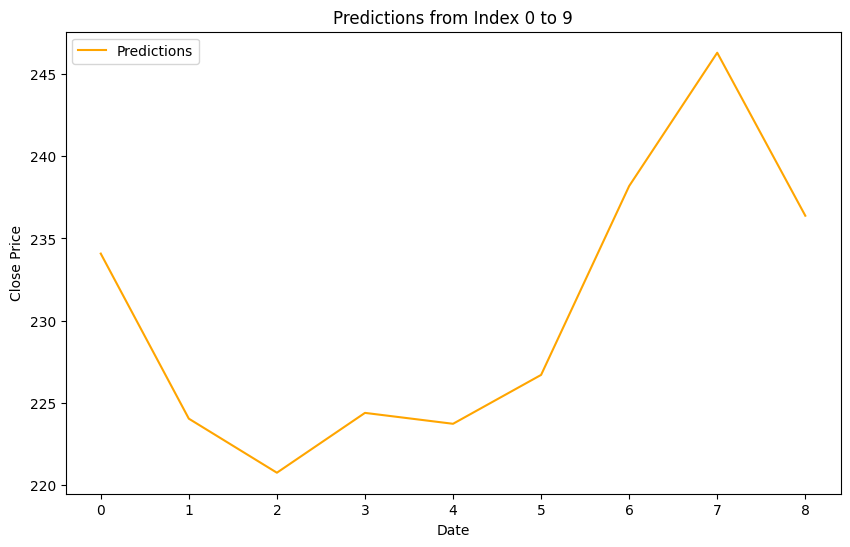

In [7]:
start_indices = [0]#range(0, 30, 5)  # Manually specify starting indices
for start_idx in start_indices:
    end_idx = start_idx + n_days_to_predict

    # Ensure the model always gets the past 9 days of data
    context_idx = start_idx - 15
    X_context = X_test.iloc[context_idx:start_idx]  # Past 15 days
    X_sub = X_train.iloc[-607:-598] # recheck on start_25 613-598
    print("xs",X_sub)
    y_true = y_test.iloc[start_idx:end_idx]

    # Reshape for LSTM input
    X_sub = X_sub.values.reshape((X_sub.shape[0], X_sub.shape[1], 1))
    print("xs",X_sub.shape)

    predictions = model.predict(X_sub)
    print(predictions.shape)
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
    

    # Plot predictions
    plt.figure(figsize=(10, 6))

    plt.plot(np.arange(len(predictions)), predictions, label="Predictions", color="orange")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title(f"Predictions from Index {start_idx} to {end_idx}")
    plt.legend()
    os.makedirs("../TSLA_pred/lstm", exist_ok=True)
    plt.savefig(f"../TSLA_pred/lstm/recheck_25.png")
    plt.show()
    plt.close()